In [1]:
import yaml
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from data import Data, SeqBPRDataset

In [2]:
with open("config/bert_config.yaml", 'r', encoding='utf-8') as f:
    args = yaml.unsafe_load(f)
data = Data(args['data'])
args

>>>> 数据加载完成: 834449 条交互, 6033 个用户, 3123 个物品


{'base_path': 'D:/Code/graduation_design/',
 'data': {'maxlen': 20,
  'is_sample': False,
  'base_model_topk': 100,
  'device': 'cuda',
  'name': 'ml-1m',
  'kindle': {'sep': ',',
   'n_item': 7844,
   'train_test_split': 0.9,
   'num_negatives': 1,
   'user_threshold': 0,
   'item_threshold': 0,
   'rating_threshold': 0},
  'ml-1m': {'sep': '::',
   'n_item': 3952,
   'train_test_split': 0.99,
   'num_negatives': 1,
   'user_threshold': 10,
   'item_threshold': 10,
   'rating_threshold': 2},
  'kuairec': {'sep': ',',
   'n_item': 10727,
   'train_test_split': 0.99,
   'num_negatives': 1,
   'user_threshold': 0,
   'item_threshold': 0,
   'rating_threshold': 0},
  'Toys_and_Games': {'sep': ',',
   'n_item': 27907,
   'train_test_split': 0.9,
   'num_negatives': 2,
   'user_threshold': 0,
   'item_threshold': 0,
   'rating_threshold': 0},
  'item_path': 'D:/Code/graduation_design/data\\ml-1m\\item.csv',
  'path': 'D:/Code/graduation_design/data\\ml-1m\\interaction.csv',
  'item_emb_path

In [73]:
np.save(f'datasets/{args["data"]["name"]}/train_samples.npy', data.train_samples)
np.save(f'datasets/{args["data"]["name"]}/test_samples.npy', data.test_samples)

In [3]:
train_samples = np.load(f'datasets/{args["data"]["name"]}/train_samples.npy', allow_pickle=True)
test_samples = np.load(f'datasets/{args["data"]["name"]}/test_samples.npy', allow_pickle=True)
train_dataset = SeqBPRDataset(train_samples, args['data']['device'])
test_dataset = SeqBPRDataset(test_samples, args['data']['device'], is_test=True)
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False)

## 评估指标

In [4]:
def nDCG(rec_items, test_set):
    DCG = lambda x: np.sum(x / np.log(np.arange(2, len(x) + 2)))
    def get_implict_matrix(rec_items, test_set):
        rel_matrix = [[0] * rec_items.shape[1] for _ in range(rec_items.shape[0])]
        for user in range(len(test_set)):
            for index, item in enumerate(rec_items[user]):
                if item in test_set[user]:
                    rel_matrix[user][index] = 1
        return np.array(rel_matrix)
    rel_matrix = get_implict_matrix(rec_items, test_set)
    ndcgs = []
    for user in range(len(test_set)):
        rels = rel_matrix[user]
        dcg = DCG(rels)
        idcg = DCG(sorted(rels, reverse=True))
        ndcg = dcg / idcg if idcg != 0 else 0
        ndcgs.append(ndcg)
    return ndcgs

def map(recommended_items, interacted_items):
    interacted_set = set(interacted_items)

    hits, precisions = [], []
    relevant_count = 0
    for i, item in enumerate(recommended_items):
        position = i + 1  # 位置从1开始计数

        is_relevant = item in interacted_set
        hits.append(1 if is_relevant else 0)
        if is_relevant:
            relevant_count += 1
            precision_at_k = relevant_count / position
            precisions.append(precision_at_k)

    if not precisions:
        return 0.0
    return sum(precisions) / len(precisions)

def mrr(results, relevant_docs):
    relevant_set = set(relevant_docs)
    rank = 0
    for i, doc_id in enumerate(results):
        if doc_id in relevant_set:
            rank = i + 1  # 排名从1开始
            break
    if rank > 0:
        reciprocal_rank = 1.0 / rank
        return reciprocal_rank
    else:
        return 0.0

def infer(model, topk):
    with torch.no_grad():
        ndcgs, maps, mrrs = [], [], []
        for batch in tqdm(test_loader, desc="计算测试集指标"):
            
            all_scores = model(batch, is_test=True)
            scores, indices = torch.topk(all_scores, topk)

            for i in range(len(batch['user_id'])):
                user_id = batch['user_id'][i].item()
                pos_item = batch['pos_item'][i].item()

                true_item_ids = data.user_interacted_item_ids[user_id]
                true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

                predicted_item_ids = np.array([indices[i].cpu().numpy().tolist()])
                maps.append(map(predicted_item_ids[0], true_item_ids))
                ndcgs.append(nDCG(np.array(predicted_item_ids), [true_item_ids]))
                mrrs.append(mrr(predicted_item_ids[0], true_item_ids))
    return {'ndcg': np.mean(ndcgs), 'map': np.mean(maps), 'mrr': np.mean(mrrs)}

## EnsRec

In [8]:
from model.old_ensrec import OldEnsRec
ensrec = OldEnsRec(args['model'], args['data'], data.n_user)
ensrec.load_state_dict(torch.load("D:\Code\graduation_design/bpr/ckpt/kuairec/ensrec_0.463.pth"), strict=True)
ensrec.eval()

KeyboardInterrupt: 

In [69]:
from model.new_ensrec_ablation.no_user import EnsRec
ensrec_no_user = EnsRec(args['model'], args['data'], data.n_user, args['data'][args['data']['name']]['n_item'])
ensrec_no_user.load_state_dict(torch.load("D:\Code\graduation_design/bpr/ckpt/Toys_and_Games/new_ensrec_no_user_0.2304.pth", map_location=torch.device('cpu')), strict=True)
ensrec_no_user.eval()

EnsRec(
  (dien): DIEN(
    (gru_cell): GRUCell(64, 64)
    (attention): AttentionLayer(
      (q_proj): Linear(in_features=64, out_features=64, bias=True)
      (k_proj): Linear(in_features=64, out_features=64, bias=True)
      (v_proj): Linear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (augru_cell): GRUCell(128, 64)
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (user_embeddings): Embedding(7356, 64)
  (item_embeddings): Embedding(27908, 64)
)

In [10]:
from model.ensrec_ablation.no_item import EnsRec
ensrec = EnsRec(args['model'], args['data'], data.n_user, args['data'][args['data']['name']]['n_item'])
ensrec.load_state_dict(torch.load(f"ckpt/{args['data']['name']}/ensrec_no_item_0.4218.pth", map_location=torch.device('cpu')), strict=True)
ensrec.eval()

>>>> 加载预计算的物品嵌入...


EnsRec(
  (dien): DIEN(
    (gru_cell): GRUCell(64, 64)
    (attention): AttentionLayer(
      (q_proj): Linear(in_features=64, out_features=64, bias=True)
      (k_proj): Linear(in_features=64, out_features=64, bias=True)
      (v_proj): Linear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (augru_cell): GRUCell(128, 64)
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
  (user_embeddings): Embedding(6033, 64)
  (item_embeddings): Embedding(3953, 64)
  (item_tower): ItemTower(
    (item_transform): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
    (preference_alignment): PreferenceAlignmentModule(
      (content_adaptor): Linear(in_features=64, out_features=64, bias=True)
      (pos

In [8]:
from model.ensrec_ablation.no_basemodel import EnsRec
ensrec = EnsRec(args['model'], args['data'], data.n_user)
ensrec.load_state_dict(torch.load(f"ckpt/{args['data']['name']}/ensrec_no_basemodel_0.4445.pth", map_location=torch.device('cpu')), strict=True)
ensrec.eval()

KeyboardInterrupt: 

In [5]:
from model.ensrec_ablation.no_basemodel_no_llm import EnsRec
ensrec = EnsRec(args['model'], args['data'], data.n_user, args['data'][args['data']['name']]['n_item'])
ensrec.load_state_dict(torch.load(f"D:\Code\graduation_design\experiment\hyperparameter_learning\ml-1m\div\ckpt_new_ensrec_div9_ml-1m\epoch5_0.4482.pth", map_location=torch.device('cpu')), strict=False)
# ensrec.load_state_dict(torch.load(f"ckpt/{args['data']['name']}/new_ensrec_no_reg_0.1666.pth", map_location=torch.device('cpu')), strict=False)
ensrec.eval()

EnsRec(
  (dien): DIEN(
    (gru_cell): GRUCell(64, 64)
    (attention): AttentionLayer(
      (q_proj): Linear(in_features=64, out_features=64, bias=True)
      (k_proj): Linear(in_features=64, out_features=64, bias=True)
      (v_proj): Linear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (augru_cell): GRUCell(128, 64)
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (user_embeddings): Embedding(6033, 64)
  (item_embeddings): Embedding(3953, 64)
)

In [47]:
from model.ensrec import EnsRec
ensrec = EnsRec(args['model'], args['data'], data.n_user)
ensrec.load_state_dict(torch.load(f"ckpt/{args['data']['name']}/ensrec_0.463.pth", map_location=torch.device('cpu')), strict=False)
ensrec.eval()

>>>> 加载预计算的物品嵌入...


EnsRec(
  (dien): DIEN(
    (gru_cell): GRUCell(64, 64)
    (attention): AttentionLayer(
      (q_proj): Linear(in_features=64, out_features=64, bias=True)
      (k_proj): Linear(in_features=64, out_features=64, bias=True)
      (v_proj): Linear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (augru_cell): GRUCell(128, 64)
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (user_embeddings): Embedding(1411, 64)
  (item_tower): ItemTower(
    (item_transform): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
    (preference_alignment): PreferenceAlignmentModule(
      (content_adaptor): Linear(in_features=64, out_features=64, bias=True)
      (position_embeddings): Embedding(20, 64)
      (transformer_layers): ModuleList(
        (0-3): 4 x TransformerBloc

In [9]:
from model.ensrec_gate import EnsRec
ensrec = EnsRec(args['model'], args['data'], data.n_user, args['data'][args['data']['name']]['n_item'])
ensrec.load_state_dict(torch.load(f"ckpt_ensrec_gate_Toys_and_Games/epoch21_0.2576.pth", map_location=torch.device('cpu')), strict=False)
ensrec.eval()

27907it [00:01, 17232.73it/s]

>>>> 加载预计算的物品嵌入...


EnsRec(
  (dien): DIEN(
    (gru_cell): GRUCell(64, 64)
    (attention): AttentionLayer(
      (q_proj): Linear(in_features=64, out_features=64, bias=True)
      (k_proj): Linear(in_features=64, out_features=64, bias=True)
      (v_proj): Linear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (augru_cell): GRUCell(128, 64)
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
  (user_embeddings): Embedding(7356, 64)
  (item_embeddings): Embedding(27907, 64)
  (item_tower): ItemTower(
    (item_transform): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
    (preference_alignment): PreferenceAlignmentModule(
      (content_adaptor): Linear(in_features=64, out_features=64, bias=True)
      (po

In [6]:
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=True)
infer(ensrec, 10)

计算测试集指标: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


{'ndcg': 0.44822011699782677,
 'map': 0.32019000643996365,
 'mrr': 0.35550733734676215}

## 集成权重可视化

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

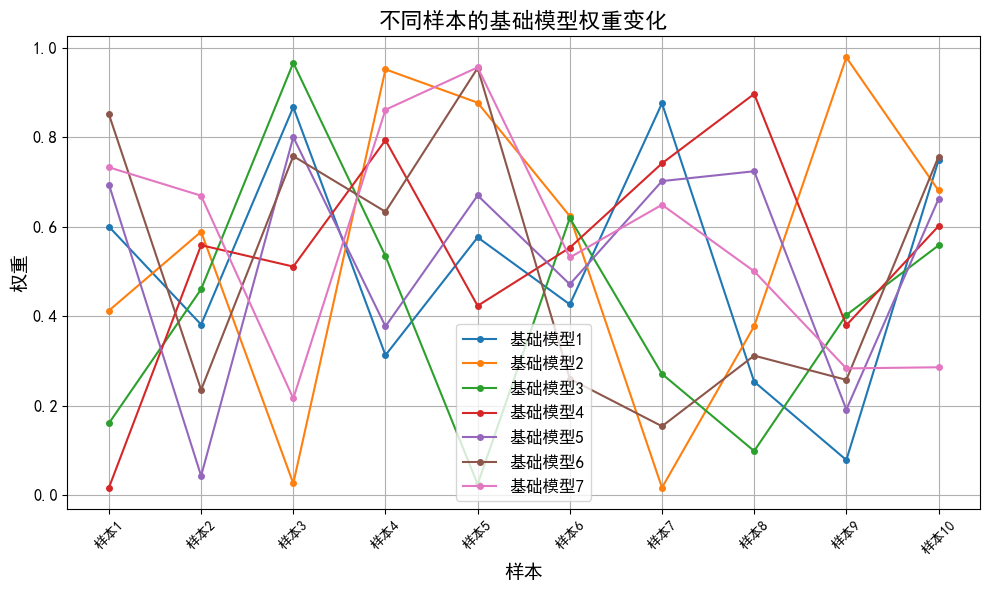

In [26]:
# 假设有100个样本和7个基础模型的权重变化数据
samples = [f'样本{i+1}' for i in range(10)]
model_weights = {f'基础模型{i+1}': np.random.rand(10) for i in range(7)}

plt.figure(figsize=(10, 6))  # 设置图表大小
for i in range(7):
    plt.plot(samples, model_weights[f'基础模型{i+1}'], label=f'基础模型{i+1}', marker='o', linestyle='-', markersize=4)

plt.title('不同样本的基础模型权重变化', fontsize=16)  # 设置标题和字体大小
plt.xlabel('样本', fontsize=14)  # 设置x轴标签和字体大小
plt.ylabel('权重', fontsize=14)  # 设置y轴标签和字体大小
plt.xticks(fontsize=10, rotation=45)  # 设置x轴刻度字体大小并旋转
plt.yticks(fontsize=12)  # 设置y轴刻度字体大小
plt.legend(fontsize=12)  # 设置图例字体大小
plt.grid(True)  # 添加网格
plt.tight_layout()  # 自动调整子图参数
plt.show()

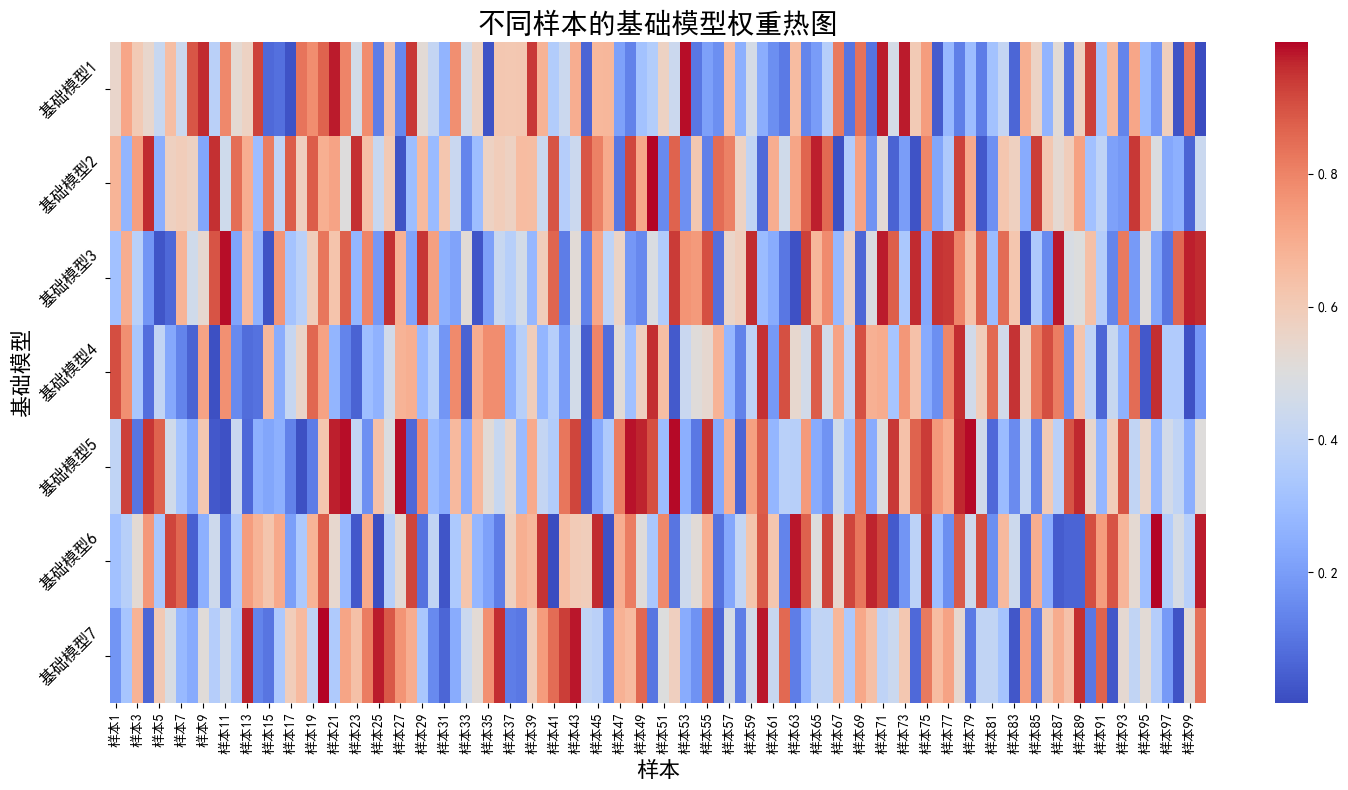

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 生成100个样本的权重数据
np.random.seed(0)
samples = [f'样本{i+1}' for i in range(100)]
model_weights = {f'基础模型{i+1}': np.random.rand(100) for i in range(7)}

# 创建数据框
df = pd.DataFrame(model_weights, index=samples)

# 绘制热图
plt.figure(figsize=(15, 8))
sns.heatmap(df.T, annot=False, cmap='coolwarm', cbar=True, linewidths=0)  # 去掉边框，转置数据
plt.title('不同样本的基础模型权重热图', fontsize=20, fontweight='bold')
plt.xlabel('样本', fontsize=16)  # 反转x轴和y轴标签
plt.ylabel('基础模型', fontsize=16)
plt.xticks(fontsize=10)  # 调整x轴刻度字体大小
plt.yticks(fontsize=12, rotation=45)  # 旋转y轴标签
plt.tight_layout()  # 自动调整子图参数
plt.show()

In [66]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

wgts = []
with torch.no_grad():
    metrics = []
    for i, batch in enumerate(test_loader):
        user_emb = ensrec.user_embeddings(batch['user_id'])  # bc, dim
        user_interaction = ensrec.item_tower(batch['user_seq'], 'user_seq')  # bc, seq_len, dim
        target_emb = ensrec.item_tower(batch['pos_item'], 'single_item')  # bc, dim
        preference = ensrec.dien(user_interaction, target_emb) + user_emb  # bc, dim

        batch_size, n_base_model, seq_len = batch['base_model_preds'].shape
        item_ids_np = batch['base_model_preds'].cpu().numpy()
        item_ids_flat = item_ids_np.reshape(-1)
        item_ids_mapped = np.array([ensrec.item_tower.item_to_idx[str(id)] for id in item_ids_flat])
        item_indices = torch.tensor(item_ids_mapped, device=batch['base_model_preds'].device)
        item_embeddings = ensrec.item_tower.item_embeddings[item_indices]
        item_embeddings = item_embeddings.reshape(batch_size, n_base_model, seq_len, -1)
        basemodel_emb = ensrec.llm_projection(item_embeddings)  # bc, n_base_model, seq_len, dim
        # base_model_focus_llm = ensrec.item_tower(batch['base_model_preds'], 'base_model')  # bc, n_base_model, seq_len, dim

        # 时间衰减权重
        time_weights = 1.0 / torch.log2(torch.arange(ensrec.seq_max_len, device=ensrec.device) + 2)
        time_weights = time_weights.view(1, 1, -1, 1)
        basemodel_emb = torch.sum(time_weights * basemodel_emb, dim=2)  # [bc, n_base_model, dim]

        # 计算基模型权重
        # [bc, n_base_model, dim] @ [bc, 1, dim] -> [bc, n_base_model, 1]
        preference = preference.unsqueeze(1).transpose(-2, -1)  # [bc, dim, 1]
        wgts_org = torch.matmul(basemodel_emb, preference).squeeze(-1)  # [bc, n_base_model]

        wgts.append(torch.nn.functional.softmax(wgts_org, dim=-1).squeeze(0).cpu())
        if (i + 1) % 100 == 0:
            break
wgts

[tensor([2.2417e-02, 2.9632e-02, 5.1519e-04, 7.9712e-04, 1.8630e-01, 5.4603e-01,
         2.1431e-01]),
 tensor([0.0010, 0.0081, 0.0013, 0.7109, 0.0075, 0.1034, 0.1678]),
 tensor([0.1442, 0.0058, 0.1138, 0.5578, 0.0119, 0.0068, 0.1597]),
 tensor([0.2305, 0.0253, 0.0108, 0.0022, 0.0348, 0.6941, 0.0024]),
 tensor([9.5941e-04, 2.8659e-05, 5.7005e-03, 1.4899e-01, 8.8021e-02, 4.6420e-02,
         7.0989e-01]),
 tensor([1.8558e-05, 2.0935e-02, 2.5750e-01, 1.9338e-01, 1.7156e-02, 5.4648e-04,
         5.1046e-01]),
 tensor([9.6854e-02, 3.0952e-03, 3.1925e-02, 2.3620e-02, 6.1879e-04, 3.1948e-02,
         8.1194e-01]),
 tensor([3.7995e-03, 4.9799e-02, 2.7304e-03, 3.9763e-02, 2.3853e-04, 8.9753e-01,
         6.1423e-03]),
 tensor([1.9512e-03, 2.6869e-02, 3.7499e-03, 9.6290e-01, 3.7471e-05, 8.0189e-05,
         4.4168e-03]),
 tensor([1.9999e-05, 6.2024e-01, 1.1352e-02, 2.5498e-05, 6.0536e-02, 2.9858e-01,
         9.2472e-03]),
 tensor([7.2888e-03, 1.8222e-05, 2.5213e-04, 8.7094e-01, 2.9298e-02, 2.

In [44]:
test_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

wgts = []
with torch.no_grad():
    metrics = []
    for i, batch in enumerate(test_loader):
        user_emb = ensrec.user_embeddings(batch['user_id'])  # bc, dim
        user_interaction = ensrec.item_embeddings(batch['user_seq'] + 1)  # bc, seq_len, dim
        target_emb = ensrec.item_embeddings(batch['pos_item'] + 1)  # bc, dim
        preference = ensrec.dien(user_interaction, target_emb) + user_emb  # bc, dim

        preference = preference.unsqueeze(1).transpose(-2, -1)  # [bc, dim, 1]
        wgts_org = torch.matmul(ensrec.base_model_emb, preference).squeeze(-1)  # [bc, n_base_model]
        wgts.append(torch.nn.functional.softmax(wgts_org, dim=-1).squeeze(0).cpu())
        if (i + 1) % 200 == 0:
            break
wgts

[tensor([1.5987e-05, 2.6029e-04, 3.1545e-05, 1.9973e-05, 9.9964e-01, 2.8448e-05,
         4.3690e-06]),
 tensor([1.1603e-15, 9.9796e-23, 1.9852e-15, 4.3982e-15, 1.0000e+00, 5.1316e-15,
         1.8532e-17]),
 tensor([3.5455e-16, 1.7206e-26, 1.0765e-16, 8.4009e-15, 1.0000e+00, 6.2515e-17,
         5.6386e-18]),
 tensor([1.3914e-17, 9.6878e-28, 3.9023e-17, 3.0328e-16, 1.0000e+00, 1.3965e-17,
         2.1333e-19]),
 tensor([4.8873e-16, 4.3816e-27, 1.3297e-16, 2.1371e-15, 1.0000e+00, 5.5624e-18,
         2.7139e-19]),
 tensor([4.3009e-17, 8.8183e-26, 1.0475e-16, 9.6010e-17, 1.0000e+00, 3.7278e-17,
         3.1513e-19]),
 tensor([1.8988e-16, 1.1741e-24, 5.0402e-16, 1.1656e-15, 1.0000e+00, 5.5198e-16,
         3.1871e-18]),
 tensor([4.4984e-16, 5.5733e-24, 9.9897e-16, 3.6687e-15, 1.0000e+00, 1.6916e-15,
         7.7761e-18]),
 tensor([9.7082e-17, 4.7068e-25, 9.4349e-16, 1.0158e-15, 1.0000e+00, 1.6311e-15,
         6.4378e-18]),
 tensor([2.4664e-16, 1.8981e-25, 2.1153e-16, 2.9791e-15, 1.0000e

100
['时间周期1', '时间周期2', '时间周期3', '时间周期4', '时间周期5', '时间周期6', '时间周期7', '时间周期8', '时间周期9', '时间周期10', '时间周期11', '时间周期12', '时间周期13', '时间周期14', '时间周期15', '时间周期16', '时间周期17', '时间周期18', '时间周期19', '时间周期20', '时间周期21', '时间周期22', '时间周期23', '时间周期24', '时间周期25', '时间周期26', '时间周期27', '时间周期28', '时间周期29', '时间周期30', '时间周期31', '时间周期32', '时间周期33', '时间周期34', '时间周期35', '时间周期36', '时间周期37', '时间周期38', '时间周期39', '时间周期40', '时间周期41', '时间周期42', '时间周期43', '时间周期44', '时间周期45', '时间周期46', '时间周期47', '时间周期48', '时间周期49', '时间周期50', '时间周期51', '时间周期52', '时间周期53', '时间周期54', '时间周期55', '时间周期56', '时间周期57', '时间周期58', '时间周期59', '时间周期60', '时间周期61', '时间周期62', '时间周期63', '时间周期64', '时间周期65', '时间周期66', '时间周期67', '时间周期68', '时间周期69', '时间周期70', '时间周期71', '时间周期72', '时间周期73', '时间周期74', '时间周期75', '时间周期76', '时间周期77', '时间周期78', '时间周期79', '时间周期80', '时间周期81', '时间周期82', '时间周期83', '时间周期84', '时间周期85', '时间周期86', '时间周期87', '时间周期88', '时间周期89', '时间周期90', '时间周期91', '时间周期92', '时间周期93', '时间周期94', '时间周期95', '时间周期96', '时间周期97', '时间周期98', '时间周期99', '时间周期100']


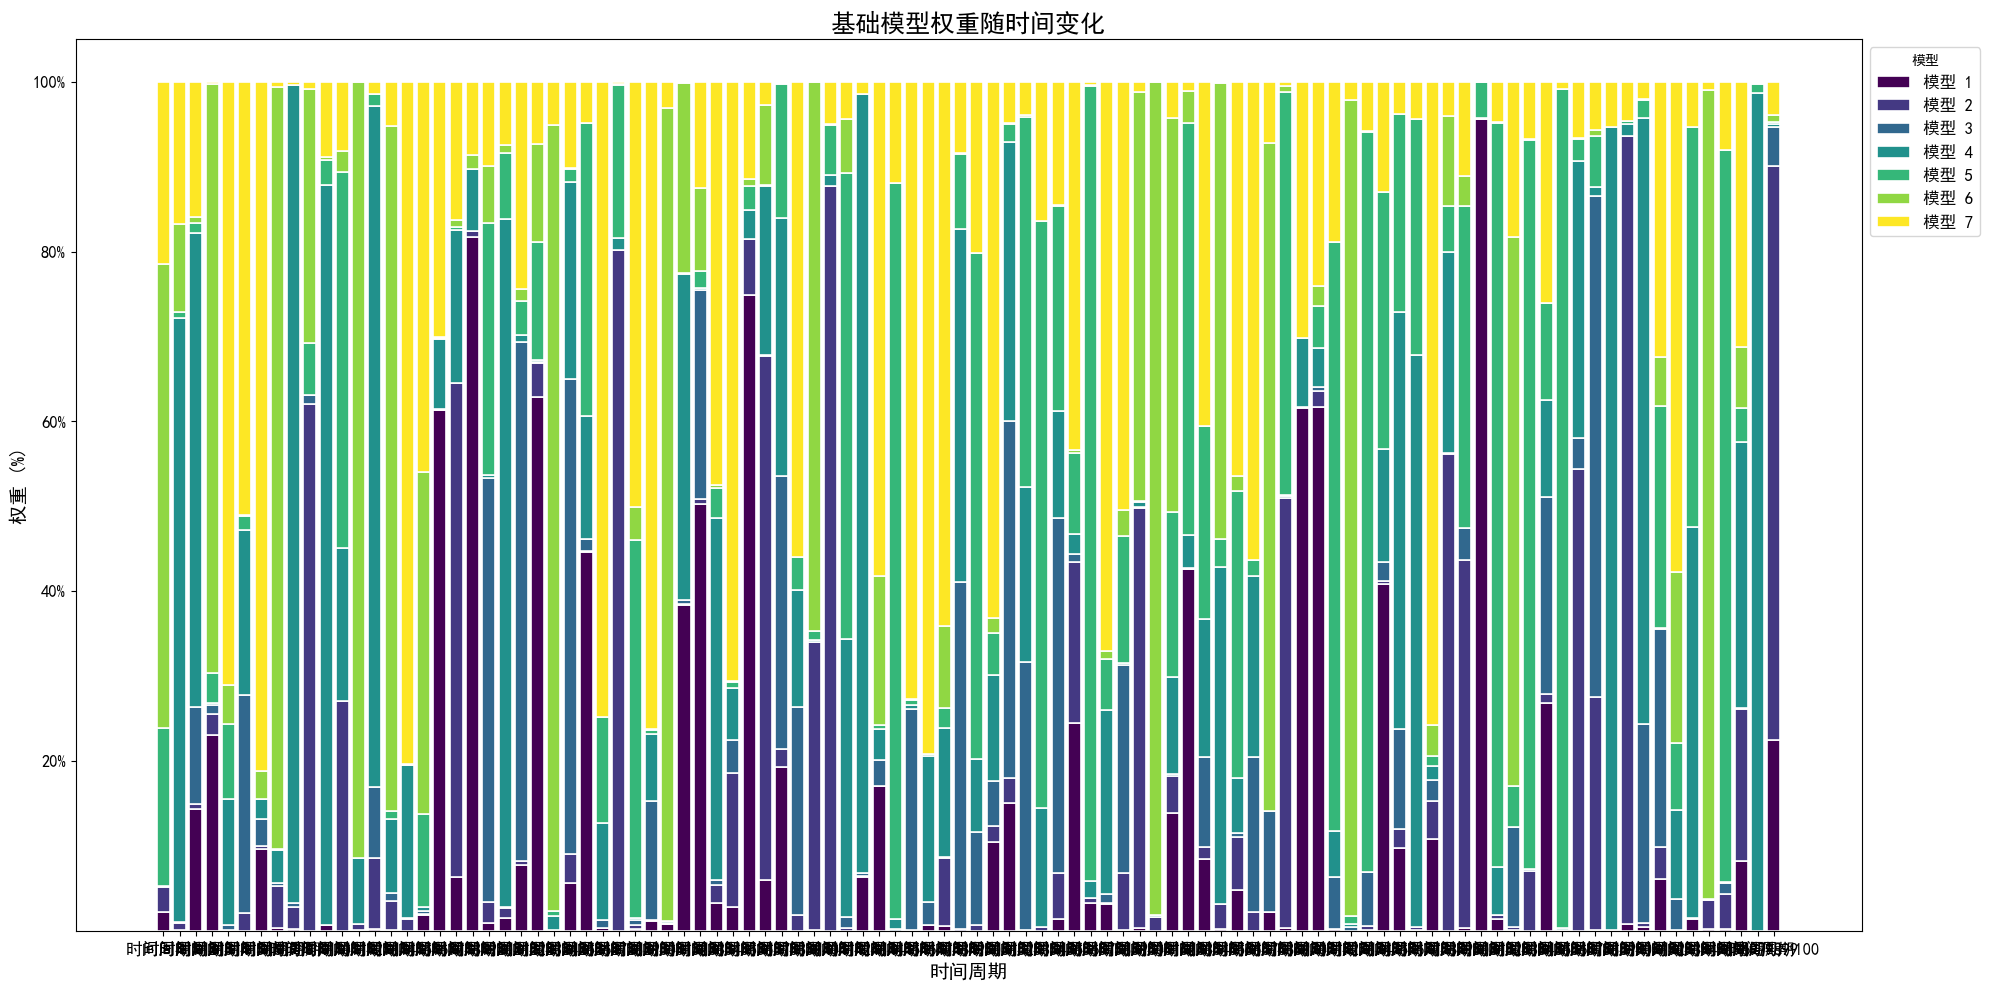

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import torch

weights = wgts
print(len(wgts))

# 模型名称
models = ['模型 1', '模型 2', '模型 3', '模型 4', '模型 5', '模型 6', '模型 7']

# 时间周期
categories = [f'时间周期{i+1}' for i in range(len(weights))]
print(categories)

# 将 weights 转换为 NumPy 数组
weights_np = np.array([w.numpy() for w in weights])

# 定义颜色
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))  # 使用更美观的颜色映射

# 绘制堆叠柱状图
fig, ax = plt.subplots(figsize=(20, 10))
x = np.arange(len(categories))  # 横轴位置
bottom = np.zeros(len(categories))  # 初始化底部位置

for i, model in enumerate(models):
    ax.bar(x, weights_np[:, i], bottom=bottom, label=model, color=colors[i], edgecolor='white', linewidth=1.2)
    bottom += weights_np[:, i]  # 更新底部位置

# 添加标题和标签
ax.set_title('基础模型权重随时间变化', fontsize=18, fontweight='bold')
ax.set_xlabel('时间周期', fontsize=14)
ax.set_ylabel('权重 (%)', fontsize=14)

# 设置 x 轴刻度
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)

# 设置 y 轴刻度为百分比形式
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
ax.tick_params(axis='y', labelsize=12)

# 添加图例
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='模型', fontsize=12)

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

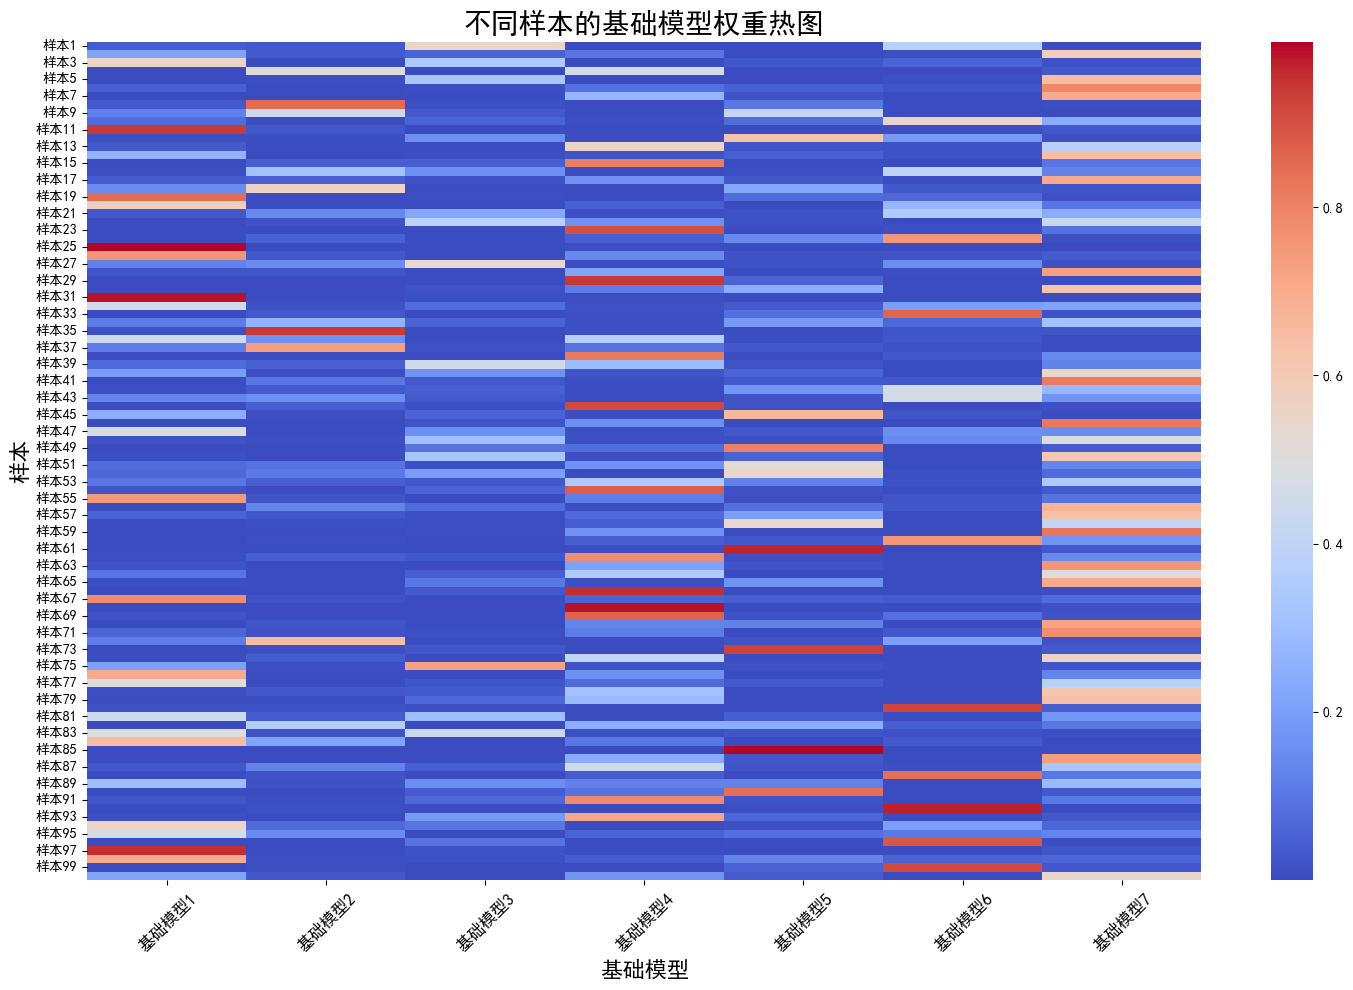

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch

df = pd.DataFrame([w.numpy() for w in wgts], columns=[f'基础模型{i+1}' for i in range(7)])

samples = [f'样本{i+1}' for i in range(len(wgts))]
df.index = samples

plt.figure(figsize=(15, 10))
sns.heatmap(df, annot=False, cmap='coolwarm', cbar=True, linewidths=0)  # 去掉边框
plt.title('不同样本的基础模型权重热图', fontsize=20, fontweight='bold')
plt.xlabel('基础模型', fontsize=16)
plt.ylabel('样本', fontsize=16)
plt.xticks(fontsize=12, rotation=45)  # 旋转x轴标签
plt.yticks(fontsize=10)  # 调整y轴刻度字体大小
plt.tight_layout()  # 自动调整子图参数
plt.show()

## 其他集成方法

### CombSum

In [13]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
metrics = []
for batch in tqdm(test_loader, desc="计算测试集指标"):
    all_scores = batch['all_item_scores'].squeeze(0).sum(dim=0, keepdim=True)
    scores, indices = torch.topk(all_scores, 10)

    for i in range(len(batch['user_id'])):
        user_id = batch['user_id'][i].item()
        pos_item = batch['pos_item'][i].item()

        true_item_ids = data.user_interacted_item_ids[user_id]
        true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

        predicted_item_ids = np.array([indices[i].cpu().numpy().tolist()])
        # score = nDCG(np.array(predicted_item_ids), [true_item_ids])
        # score = map(predicted_item_ids[0], true_item_ids)
        score = mrr(predicted_item_ids[0], true_item_ids)
        metrics.append(score)
np.mean(metrics)

计算测试集指标: 100%|██████████| 14904/14904 [00:22<00:00, 666.08it/s]


0.15995455571743816

### CombMNZ

In [16]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
metrics = []
for batch in tqdm(test_loader, desc="计算测试集指标"):
    all_scores = batch['all_item_scores'].squeeze(0).sum(dim=0, keepdim=True)
    item_ids_np = batch['base_model_preds'].cpu().numpy().reshape(-1)
    item_indices = torch.tensor(np.array([data.item_to_id[id] for id in item_ids_np]), device="cuda")
    all_item_counts = torch.bincount(item_indices, minlength=data.n_item)
    all_scores = all_scores * all_item_counts.unsqueeze(0)
    scores, indices = torch.topk(all_scores, 10)

    user_id = batch['user_id'].item()
    pos_item = batch['pos_item'].item()

    true_item_ids = data.user_interacted_item_ids[user_id]
    true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

    predicted_item_ids = np.array([indices[0].cpu().numpy().tolist()])
    score = nDCG(np.array(predicted_item_ids), [true_item_ids])
    # score = map(predicted_item_ids[0], true_item_ids)
    # score = mrr(predicted_item_ids[0], true_item_ids)
    metrics.append(score)
np.mean(metrics)

计算测试集指标: 100%|██████████| 14904/14904 [00:29<00:00, 502.75it/s]


0.22983398313794107

### ​CombANZ

In [53]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
metrics = []
for batch in tqdm(test_loader, desc="计算测试集指标"):
    all_scores = batch['all_item_scores'].squeeze(0).sum(dim=0, keepdim=True)
    item_ids_np = batch['base_model_preds'].cpu().numpy().reshape(-1)
    item_indices = torch.tensor(np.array([data.item_to_id[id] for id in item_ids_np]), device="cuda")
    all_item_counts = torch.bincount(item_indices, minlength=data.n_item)
    # 将计数为0的位置替换为无穷大
    all_item_counts[all_item_counts == 0] = 1_000_000_000
    all_scores = all_scores / all_item_counts.unsqueeze(0)
    scores, indices = torch.topk(all_scores, 10)

    user_id = batch['user_id'].item()
    pos_item = batch['pos_item'].item()

    true_item_ids = data.user_interacted_item_ids[user_id]
    true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

    predicted_item_ids = np.array([indices[0].cpu().numpy().tolist()])
    print(predicted_item_ids.shape)
    score = nDCG(np.array(predicted_item_ids), [true_item_ids])
    # score = map(predicted_item_ids[0], true_item_ids)
    # score = mrr(predicted_item_ids[0], true_item_ids)
    metrics.append(score)
np.mean(metrics)

计算测试集指标:   0%|          | 11/25369 [00:00<04:00, 105.36it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   0%|          | 40/25369 [00:00<03:07, 134.98it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   0%|          | 112/25369 [00:00<01:58, 213.06it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   1%|          | 134/25369 [00:00<02:00, 208.71it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   1%|          | 188/25369 [00:00<01:44, 240.12it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   1%|          | 251/25369 [00:01<01:47, 234.39it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   1%|          | 276/25369 [00:01<01:52, 222.89it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   1%|▏         | 326/25369 [00:01<01:50, 226.40it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   1%|▏         | 376/25369 [00:01<01:46, 234.28it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   2%|▏         | 427/25369 [00:01<01:43, 240.42it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   2%|▏         | 499/25369 [00:02<01:23, 296.28it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   2%|▏         | 566/25369 [00:02<01:45, 235.02it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


KeyboardInterrupt: 

### 根据基模型加权

In [83]:
ml_wgts = [0.1535, 0.1105, 0.1559, 0.1684, 0.1682, 0.1170, 0.1265]
kuairec_wgts = [0.15, 0.1101, 0.1562, 0.1477, 0.1615, 0.1183, 0.1562]
amazon_wgts = [0.1899, 0.0627, 0.0429, 0.1306, 0.2539, 0.1007, 0.2193]

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
metrics = []
for batch in tqdm(test_loader, desc="计算测试集指标"):
    all_scores = batch['all_item_scores'] * torch.tensor(amazon_wgts, device=batch['all_item_scores'].device).view(1, -1, 1)
    all_scores = all_scores.squeeze(0).sum(dim=0, keepdim=True)
    scores, indices = torch.topk(all_scores, 10)

    user_id = batch['user_id'][0].item()
    pos_item = batch['pos_item'][0].item()

    true_item_ids = data.user_interacted_item_ids[user_id]
    true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

    predicted_item_ids = np.array([indices[0].cpu().numpy().tolist()])
    score = nDCG(np.array(predicted_item_ids), [true_item_ids])
    # score = map(predicted_item_ids[0], true_item_ids)
    # score = mrr(predicted_item_ids[0], true_item_ids)
    metrics.append(score)
np.mean(metrics)

计算测试集指标:   3%|▎         | 226/8345 [00:00<00:23, 339.11it/s]

### AEM

In [33]:
from model.aem import AEM
aem = AEM(args['model'], args['data'], data.n_user, 10737)
aem.load_state_dict(torch.load("ckpt/kuairec/aem_0.4313.pth"))
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=True)
infer(aem, 10, 'ndcg')

计算测试集指标: 100%|██████████| 50/50 [00:05<00:00,  9.03it/s]


np.float64(0.43130702216297756)

### Stack

In [23]:
from model.stack import StackingModel
stack_model = StackingModel(args['model'], args['data'], data.n_user)
stack_model.load_state_dict(torch.load("D:\Code\graduation_design\\bpr\ckpt\kuairec\stack_0.4256.pth"))
stack_model.eval()
infer(stack_model, 10, 'mrr')

计算测试集指标:   0%|          | 0/50 [00:00<?, ?it/s]

计算测试集指标: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


0.3310864184321948

## 基础模型

In [9]:
base_model_results = {}
for base_model in args['data']['base_model']:
    model = np.load(args['data']['base_model_path'] + f"/{base_model}.npy")
    scores = []
    phar = tqdm(test_samples, desc=f"计算{base_model}测试集指标...")
    for case in phar:
        user_id = case['user_id']
        pos_item = case['pos_item']

        interaction_idx = data.get_interaction_index(user_id, data.item_to_id[pos_item])
        assert interaction_idx != -1

        predicted_item_ids = model[interaction_idx][2:2+10]
        true_item_ids = data.user_interacted_item_ids[user_id]
        true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

        predicted_items = np.array([predicted_item_ids])
        # score = nDCG(np.array(predicted_items), [true_item_ids])
        # score = map(predicted_items[0], true_item_ids)
        score = mrr(predicted_items[0], true_item_ids)
        scores.append(score)

        phar.set_postfix(score=score)
    print(f"{base_model}: {round(np.mean(scores), 4)}")

计算acf测试集指标...: 100%|██████████| 24024/24024 [00:28<00:00, 831.93it/s, score=0]    


acf: 0.23418990070775786


计算fdsa测试集指标...: 100%|██████████| 24024/24024 [00:34<00:00, 692.97it/s, score=0]    


fdsa: 0.10429978421049849


计算harnn测试集指标...: 100%|██████████| 24024/24024 [00:27<00:00, 875.79it/s, score=0]    


harnn: 0.1450569106819107


计算caser测试集指标...: 100%|██████████| 24024/24024 [00:29<00:00, 819.38it/s, score=0]    


caser: 0.23844888577031434


计算pfmc测试集指标...: 100%|██████████| 24024/24024 [00:34<00:00, 701.10it/s, score=0]    


pfmc: 0.2854783939605368


计算sasrec测试集指标...: 100%|██████████| 24024/24024 [00:33<00:00, 717.91it/s, score=0]    


sasrec: 0.0939187135615707


计算anam测试集指标...: 100%|██████████| 24024/24024 [00:28<00:00, 833.26it/s, score=0]    

anam: 0.24562339115910545


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=True)
for metric in ['ndcg', 'map', 'mrr']:
    print(f"{metric}: {infer(ensrec, 10, metric)}")

计算测试集指标: 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


ndcg: 0.26564731282703286


计算测试集指标: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


map: 0.19748149569650228


计算测试集指标: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s]

mrr: 0.20382932247867835


In [ ]:
base_model_results = {}
model = np.load("D:\Code\graduation_design\\basemodel_results\Toys_and_Games\\anam.npy")
ndcgs = []
maps = []
mrrs = []
phar = tqdm(test_samples, desc=f"计算测试集指标...")
for case in phar:
    user_id = case['user_id']
    pos_item = case['pos_item']

    interaction_idx = data.get_interaction_index(user_id, data.item_to_id[pos_item])
    assert interaction_idx != -1
    predicted_item_ids = model[interaction_idx][2:2+10]
    true_item_ids = data.user_interacted_item_ids[user_id]
    true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

    predicted_items = np.array([predicted_item_ids])
    ndcgs.append(nDCG(np.array(predicted_items), [true_item_ids]))
    maps.append(map(predicted_items[0], true_item_ids))
    mrrs.append(mrr(predicted_items[0], true_item_ids))

print(f"ndcg: {round(np.mean(ndcgs), 4)} map: {round(np.mean(maps), 4)} mrr: {round(np.mean(mrrs), 4)}")

计算测试集指标...: 100%|██████████| 14904/14904 [00:02<00:00, 6323.74it/s] 


ndcg: 0.2766 map: 0.2088 mrrs: 0.2413


In [82]:
import numpy as np

# 模型分数
scores = {
    "caser": 0.36663333,
    "pfmc": 0.3661,
    "acf": 0.33413333,
    "anam": 0.27546667,
    "fdsa": 0.2405,
    "harnn": 0.33933333,
    "sasrec": 0.25473333
}

# 计算 Softmax 权重
def calculate_softmax_weights(scores):
    values = np.array(list(scores.values()))
    softmax_weights = values / np.sum(values)  # 归一化
    return dict(zip(scores.keys(), softmax_weights))

weights = calculate_softmax_weights(scores)

# 打印结果
for model, weight in weights.items():
    print(f"{model}: {weight:.4f}")

caser: 0.1684
pfmc: 0.1682
acf: 0.1535
anam: 0.1265
fdsa: 0.1105
harnn: 0.1559
sasrec: 0.1170


In [81]:
import numpy as np

"""
||||
|-|-|-|
|0.4378|0.3134|0.3487|
|0.4444|0.3110|0.3429|
|0.4074|0.2849|0.3101|
|0.3210|0.2381|0.2673|
|0.3192|0.1986|0.2037|
|0.4098|0.2890|0.3192|
|0.3405|0.2155|0.2082|
"""

data = np.array([
    [0.4378, 0.3134, 0.3487],
    [0.4444, 0.3110, 0.3429],
    [0.4074, 0.2849, 0.3101],
    [0.3210, 0.2381, 0.2673],
    [0.3192, 0.1986, 0.2037],
    [0.4098, 0.2890, 0.3192],
    [0.3405, 0.2155, 0.2082]
])

# 计算每一行的均值
row_means = np.mean(data, axis=1)

# 打印结果
print(row_means)

[0.36663333 0.3661     0.33413333 0.27546667 0.2405     0.33933333
 0.25473333]
